First the google drive is mounted so that the images and model can be saved


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Here the UNET neutral network is defined. The implementation references https://github.com/WeidiXie/pytorch-unet-1/tree/master and the original architecture from https://arxiv.org/pdf/1505.04597.pdf. UNET is a Convolution Neural Network that is used for image segmentation. It is helpful in the fashion classification problem since it can segment an image into different pieces by objects such as clothing. The architecture of UNET involves a 2 part process. First there is an encoder that downscales an image through 4 layers of double convolutions(every two layers the channels increase)  while defining features. After that, there is a decoder process that upsamples and uses skip connections to combine features to specific locations. The final layers map the features to classifications. self.conv_binary and self.conv_multiclass are the maps to person and background and the 7 labels for clothing.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import io
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# Create UNET Neutral Network
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)


        self.conv_binary = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1) # 2 classes: person and background
        self.conv_multiclass = nn.Conv2d(in_channels=64, out_channels=7, kernel_size=1) # 7 classes including background

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out_binary = self.conv_binary(x)
        out_multiclass = self.conv_multiclass(x)
        return out_binary, out_multiclass


Here are 2 functions defined to help map RGB colors of clothing to and from the labels given by labels.txt.

In [ ]:
def rgb_to_index(mask):
    """Define a mapping from RGB tuples to classification indices."""
    color_map = {
        (0, 0, 0): 0,        # Background is black
        (128, 0, 0): 1,      # Skin is red
        (0, 128, 0): 2,      # Hair is green
        (128, 128, 0): 3,    # Tshirt is yellow
        (0, 0, 128): 4,      # Shoes is dark blue
        (128, 0, 128): 5,    # Pants is pink
        (0, 128, 128): 6     # Dress is cyan

    }
    class_map = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    for k, v in color_map.items():
        color_mask = np.all(mask == np.array(k, dtype=np.uint8), axis=-1)
        class_map[color_mask] = v
    return class_map

def index_to_rgb(mask):
    color_map_reverse = {
        0: (0, 0, 0),       # Background is black
        1: (128, 0, 0),     # Skin is red
        2: (0, 128, 0),     # Hair is green
        3: (128, 128, 0),   # Tshirt is yellow
        4: (0, 0, 128),     # Shoes is dark blue
        5: (128, 0, 128),   # Pants is pink
        6: (0, 128, 128)    # Dress is cyan
    }
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for k, v in color_map_reverse.items():
        rgb_image[mask == v] = k
    return rgb_image

Here the fashion dataset is parsed and divided into person masks and clothes masks for the 2 different classification problems.

In [ ]:
class ClothesDataset(Dataset):
    def __init__(self, image_dir, label_dir, indices, transform=None):
        self.image_paths = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.jpg')]
        self.image_paths = [self.image_paths[i] for i in indices]
        self.label_dir = label_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = io.imread(img_path)
        mask_person_path = os.path.join(self.label_dir, os.path.basename(img_path).replace('.jpg', '_person.png'))
        mask_clothes_path = os.path.join(self.label_dir, os.path.basename(img_path).replace('.jpg', '_clothes.png'))

        mask_person = io.imread(mask_person_path, as_gray=True)
        mask_clothes = io.imread(mask_clothes_path, as_gray=False)
        mask_person = (mask_person > 0).astype(np.float32)
        mask_clothes = rgb_to_index(mask_clothes)

        if self.transform:
            img = self.transform(img)
            mask_person = torch.tensor(mask_person, dtype=torch.long)
            mask_clothes = torch.tensor(mask_clothes, dtype=torch.long)

        return img, mask_person, mask_clothes

transform = transforms.Compose([
    transforms.ToTensor(),
])


The 600 fashion images are divided in a 50% training, 10% validation and 40% testing distribution as suggested and loaded. Then the model and optimizer is defined.

In [ ]:
total_indices = list(range(600))
# 50% train, 10% validation, 40% test
train_val_indices, test_indices = train_test_split(total_indices, test_size=0.4, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.1 / 0.6, random_state=42)  # 10% of total is 16.67% of 60%

train_dataset = ClothesDataset('/content/drive/MyDrive/project3/images/', '/content/drive/MyDrive/project3/labels/', train_indices, transform)
val_dataset = ClothesDataset('/content/drive/MyDrive/project3/images/', '/content/drive/MyDrive/project3/labels/', val_indices, transform)
test_dataset = ClothesDataset('/content/drive/MyDrive/project3/images/', '/content/drive/MyDrive/project3/labels/', test_indices, transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Uses CUDA gpu is exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and optimizer
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


This function trains the model and uses different loss functions depending on if the classification problem is person or clothing. The loss is also calculated and printed for both training and validation. The model is trained and saved. Due to computation limitations on the Google Collab free plan, I trained the model on my personal computer and uploaded it to my Google Drive.

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, task_type, device):
    model.to(device)
    model.train()

    if task_type == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif task_type == 'multiclass':
        criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_loss = 0
        for images, mask_binary, mask_multiclass in train_loader:
            images = images.to(device)

            # Choose the correct mask for the task type
            if task_type == 'binary':
                masks = mask_binary
                masks = masks.to(device).float().unsqueeze(1)
            else:
                masks = mask_multiclass
                masks = masks.to(device)

            optimizer.zero_grad()

            outputs_binary, outputs_multiclass = model(images)
            outputs = outputs_binary if task_type == 'binary' else outputs_multiclass

            # Calculate loss
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        # Calculate average losses
        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, mask_binary, mask_multiclass in val_loader:
                images = images.to(device)
                if task_type == 'binary':
                    masks = mask_binary
                    masks = masks.to(device).float().unsqueeze(1)
                else:
                    masks = mask_multiclass
                    masks = masks.to(device)

                outputs_binary, outputs_multiclass = model(images)
                outputs = outputs_binary if task_type == 'binary' else outputs_multiclass

                # Calculate validation loss
                val_loss += criterion(outputs, masks).item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        model.train()

train_model(model, train_loader, val_loader, optimizer, num_epochs=10, task_type='binary', device=device)
torch.save(model.state_dict(), '/content/drive/MyDrive/project3/unet_model.pth')
train_model(model, train_loader, val_loader, optimizer, num_epochs=10, task_type='multiclass', device=device)
torch.save(model.state_dict(), '/content/drive/MyDrive/project3/unet_model.pth')




The trained model is loaded and used for testing. The model predicts the pixel-level classification for both person and background and the 7 clothing label task and saves them as images. Then the function displays one image and the predicted label for both the person classification and the clothes classification.


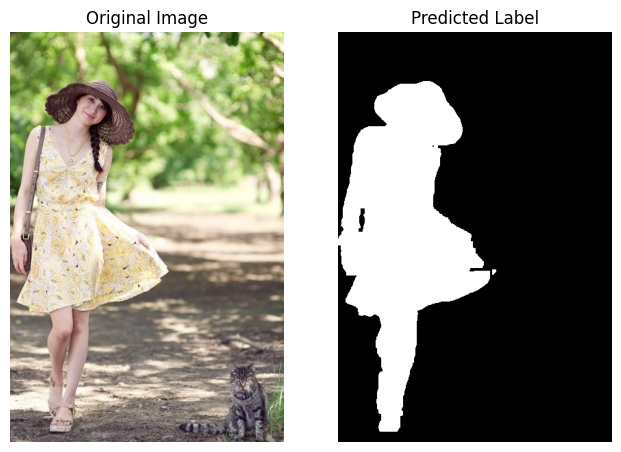

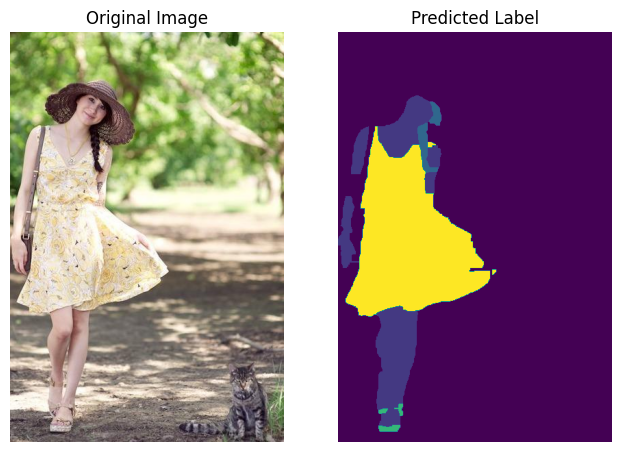

Image 0: Person Accuracy = 0.7826, Clothes Accuracy = 0.8008
Image 1: Person Accuracy = 0.7776, Clothes Accuracy = 0.8594
Image 2: Person Accuracy = 0.7677, Clothes Accuracy = 0.8367
Image 3: Person Accuracy = 0.7931, Clothes Accuracy = 0.8703
Image 4: Person Accuracy = 0.7365, Clothes Accuracy = 0.8004
Image 5: Person Accuracy = 0.7590, Clothes Accuracy = 0.8179
Image 6: Person Accuracy = 0.8061, Clothes Accuracy = 0.8539
Image 7: Person Accuracy = 0.7587, Clothes Accuracy = 0.8541
Image 8: Person Accuracy = 0.7689, Clothes Accuracy = 0.8065
Image 9: Person Accuracy = 0.7886, Clothes Accuracy = 0.8426
Image 10: Person Accuracy = 0.7617, Clothes Accuracy = 0.8420
Image 11: Person Accuracy = 0.7880, Clothes Accuracy = 0.8686
Image 12: Person Accuracy = 0.7664, Clothes Accuracy = 0.7867
Image 13: Person Accuracy = 0.7611, Clothes Accuracy = 0.8321
Image 14: Person Accuracy = 0.7664, Clothes Accuracy = 0.8216
Image 15: Person Accuracy = 0.7810, Clothes Accuracy = 0.8205
Image 16: Person A

In [ ]:
model = UNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/project3/unet_model.pth'))
model.eval()

def test_model(model, dataloader, result_dir, device='cpu'):
    model.to(device)
    model.eval()

    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    print_one = True
    with torch.no_grad():
        for i, (images, mask_person, mask_clothes) in enumerate(dataloader):
            images = images.to(device)
            outputs_person, outputs_clothes = model(images)
            preds_person = torch.sigmoid(outputs_person) > 0.5
            preds_clothes = torch.argmax(outputs_clothes, dim=1)

            for j in range(images.size(0)):
                preds_person_norm = preds_person[j].float().cpu().squeeze()
                preds_clothes_norm = preds_clothes[j].float().cpu().numpy()
                max_val = preds_clothes_norm.max()
                if max_val > 0:
                    preds_clothes_norm /= max_val

                plt.imsave(os.path.join(result_dir, f"{i}_{j}_person.png"), preds_person_norm, cmap='gray')
                plt.imsave(os.path.join(result_dir, f"{i}_{j}_clothes.png"), preds_clothes_norm, cmap='viridis')

            if print_one:
                plt.figure(figsize=(12, 8))
                plt.subplot(1, 3, 1)
                plt.imshow(images[0].cpu().permute(1, 2, 0))
                plt.title('Original Image')
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.imshow(mask_person[0].cpu().squeeze(), cmap='gray')
                plt.title('Predicted Label')
                plt.axis('off')
                plt.show()

                plt.figure(figsize=(12, 8))
                plt.subplot(1, 3, 1)
                plt.imshow(images[0].cpu().permute(1, 2, 0))
                plt.title('Original Image')
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.imshow(mask_clothes[0].cpu().numpy(), cmap='viridis')
                plt.title('Predicted Label')
                plt.axis('off')
                plt.show()
                print_one = False

            # Calculate and print accuracies for each image
            person_accuracy = accuracy_score(mask_person.cpu().numpy().flatten(), preds_person.cpu().numpy().flatten())
            clothes_accuracy = accuracy_score(mask_clothes.cpu().numpy().flatten(), preds_clothes.cpu().numpy().flatten())
            print(f"Image {i}: Person Accuracy = {person_accuracy:.4f}, Clothes Accuracy = {clothes_accuracy:.4f}")



test_model(model, test_loader, '/content/drive/MyDrive/project3/results-seg')